In [25]:
# useful function to split formulas into atom types in a given system

def split(word):
    data = [char for char in word]
    data = [x for x in data if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]   
    return data

In [54]:
import numpy as np
import pandas as pd
from ase.geometry.analysis import Analysis
from pymatgen.core import Lattice, Structure
from pymatgen.io.cif import CifParser
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core.composition import Composition
import matplotlib.pyplot as plt
import seaborn as sns

# uses pymatgens cif parser to read in a structure
parser = CifParser(r"C:\Users\Calum\Documents\Coding\Python\PDielec_Dev\PDielec\testfiles\D2TestFiles\Concatenated\D2.cif")

# generates a struct file which is a pymatgen formatted file that analysis can be performed on
struct = parser.get_structures()[0]
cell = struct.lattice.matrix

# uses a pymatgen tool that converts struct format into ASE based Atoms format
atoms = AseAtomsAdaptor.get_atoms(struct)

# performs a geometry analysis using ASE geometry analysis tool
ana = Analysis(atoms)

In [55]:
from itertools import combinations_with_replacement, cycle, product, permutations

# uses the reduced formula tool from pymatgen to obtain atom types
comp = split(struct.composition.reduced_formula)

# uses itertools to obtain combinations of 2, 3 and 4 atom lists these will be used to find bond length,  bond angle 
# and dihedral angeles for the molecule

bonds = list(combinations_with_replacement(comp, 2))
angles = list(product(comp, repeat=3))
dihedrals = list(product(comp, repeat=4))

# tidying up angles list

#avoids duplication of single permetations
perm = list(permutations(comp, 3))
perm = perm[:len(comp)]

comb_replace = list(combinations_with_replacement(comp, 3))

# remove tuples including same atom 3 times as we want to keep in the final list
for index, tuple in enumerate(comb_replace):
    if tuple[0] == tuple[1] and tuple[1] == tuple[2]:
      comb_replace.remove(tuple)  

for element in comb_replace:
    if element in angles:
        angles.remove(element)
for element in perm:
    if element in angles:
        angles.remove(element)

        
# tidying up dihedrals list

#avoids duplication of single permetations
perm = list(permutations(comp, 4))
perm = perm[:len(comp)]

comb_replace = list(combinations_with_replacement(comp, 4))

# remove tuples including same atom 4 times as we want to keep in the final list
for index, tuple in enumerate(comb_replace):
    if tuple[0] == tuple[1] and tuple[1] == tuple[2] and tuple[2] == tuple[3]:
      comb_replace.remove(tuple)  

for element in comb_replace:
    if element in dihedrals:
        dihedrals.remove(element)
for element in perm:
    if element in dihedrals:
        dihedrals.remove(element)
"""
        This uses the geometry analysis tools and the list of lengths/angles/dihedrals to perform all the measurements and 
        make panda dataframes.

each data from contains three columns, the first is atoms, the second is a list of tuples of atom numbers and the third is 
a list of tuples of lengths/angles/dihedrals

The three Dataframes are Bondsdf, Anglessdf and Dihedralssdf. If the atom numbering remains the same for first a last 
structure in an optimisation (which they should if you read in via PDielec for instance) then looking at differences between lists should provide you with RMSD values.

import pandas as pd
"""
# creates a pandas data structure for bond lengths

data = {"Atoms":[],"Atom Numbers":[],"Bond Length":[]};

for i in range(len(bonds)):
    a, b = bonds[i]
    bond_list = ana.get_bonds(a, b, unique=True)
    temp = bond_list[0]

    # this removes any empty bond lists for the types created via combinations 
    if temp:
        bondvalues = ana.get_values(bond_list)
        bondvalues = bondvalues[0]
        data["Atoms"].append(bonds[i])
        data["Atom Numbers"].append(temp)
        data["Bond Length"].append(bondvalues)

Bondsdf = pd.DataFrame(data)

# creates a pandas data structure for bond angles

data = {"Atoms":[],"Atom Numbers":[],"Bond Angles":[]};

for i in range(len(angles)):
    a, b, c = angles[i]
    angles_list = ana.get_angles(a, b, c, unique=True)
    temp = angles_list[0]
    if temp:
        anglevalues = ana.get_values(angles_list)
        data["Atoms"].append(angles[i])
        data["Atom Numbers"].append(temp)
        data["Bond Angles"].append(anglevalues)

Anglessdf = pd.DataFrame(data)


# creates a pandas data structure for dihedral angles

data = {"Atoms":[],"Atom Numbers":[],"Dihedrals":[]};

for i in range(len(dihedrals)):
    a, b, c, d = dihedrals[i]
    dihedrals_list = ana.get_dihedrals(a, b, c, d, unique=True)
    temp = dihedrals_list[0]
    if temp:
        dihedralsvalues = ana.get_values(dihedrals_list)
        data["Atoms"].append(dihedrals[i])
        data["Atom Numbers"].append(temp)
        data["Dihedrals"].append(dihedralsvalues)

Dihedralssdf = pd.DataFrame(data)

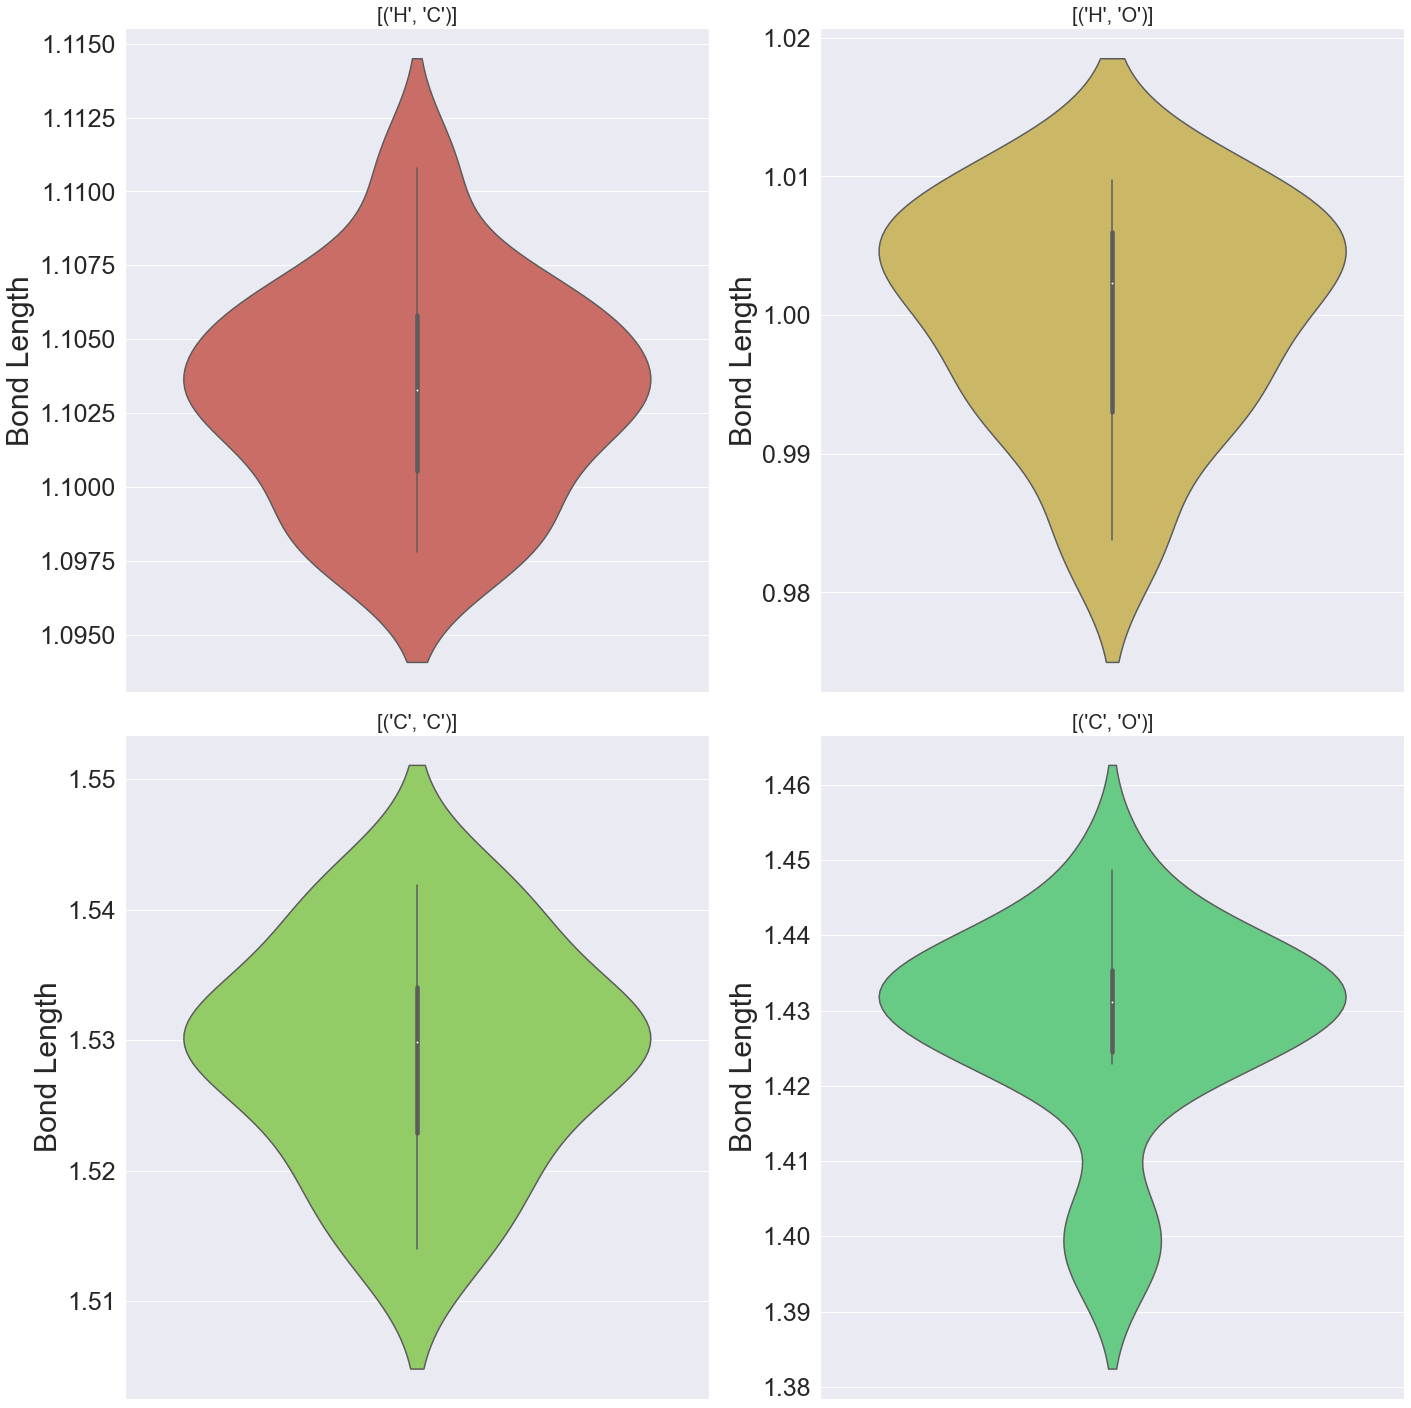

In [56]:
# reshaping of Bonds Dataframe to make it suitable for plotting

Bondssns = Bondsdf.drop(['Atom Numbers'], axis=1)
Bondssns = Bondssns.explode('Bond Length')
Bondssns['Bond Length'] = Bondssns['Bond Length'].astype('float')
Bondssns = Bondssns.set_index('Atoms')

#decides homany plots we need

nplots = len(Bondsdf["Atoms"])

if nplots <= 6:
    ncol = 2
elif nplots <= 9:
    ncol = 3
elif nplots <= 16:
    ncol = 4

nrow = int(nplots / ncol) + (nplots % ncol > 0)



# all seaborn settings should be defined before use of subplots, then all subplots are formatted in the same way
sns.set(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":30, "ytick.labelsize":25})
palette = cycle(sns.color_palette("hls", 8))

fig, ax = plt.subplots(nrow, ncol, figsize=(20, 20))

# loops over data and plots all bondlengths
counter = 0
for j in Bondsdf["Atoms"]:
    sns.violinplot(y="Bond Length", data=Bondssns.loc[[j]], ax=ax.flat[counter], color=next(palette)).set_title([j])
    counter += 1


if (nplots % ncol > 0) == 1:
    ax.flat[-1].set_visible(False)
    
plt.tight_layout()
plt.show();

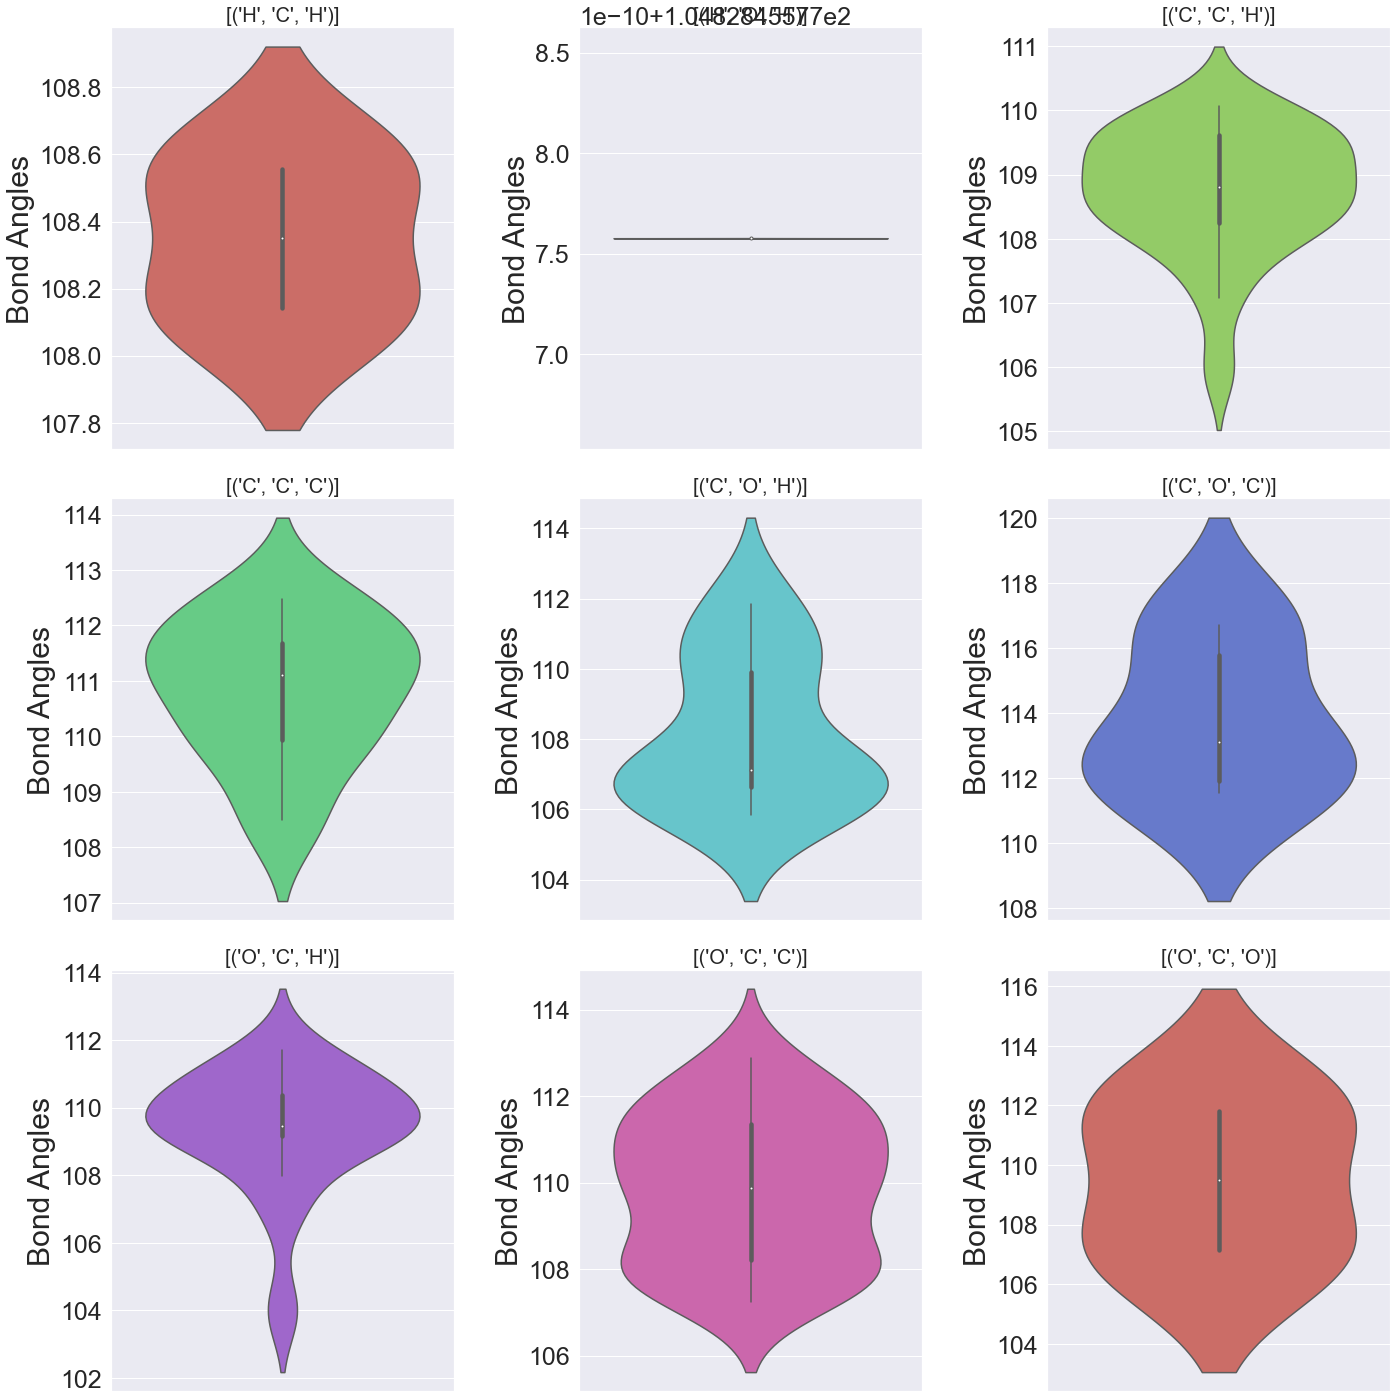

In [57]:


Anglessns = Anglessdf.drop(['Atom Numbers'], axis=1)
Anglessns = Anglessns.explode('Bond Angles')
Anglessns = Anglessns.explode('Bond Angles')
Anglessns['Bond Angles'] = Anglessns['Bond Angles'].astype('float')
Anglessns = Anglessns.set_index('Atoms')


#Filters small (< 20) and large (> 143) angles. These a probably not chemically relevant
Anglessns = Anglessns.loc[(Anglessns['Bond Angles']>20) & (Anglessns['Bond Angles']< 143)]

nplots = len(set(Anglessns.index.tolist()))

if nplots <= 6:
    ncol = 2
elif nplots <= 9:
    ncol = 3
elif nplots <= 16:
    ncol = 4

nrow = int(nplots / ncol) + (nplots % ncol > 0)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":30, "ytick.labelsize":25})
palette = cycle(sns.color_palette("hls", 8))

fig, ax = plt.subplots(nrow, ncol, figsize=(20, 20))

counter = 0
for j in Anglessdf["Atoms"]:
    if j in Anglessns.index:
        sns.violinplot(y="Bond Angles", data=Anglessns.loc[[j]], ax=ax.flat[counter], label=[j], color=next(palette)).set_title([j])
        counter += 1


if (nplots % ncol > 0) == 1:
    ax.flat[-1].set_visible(False)
    
plt.tight_layout()
plt.show();

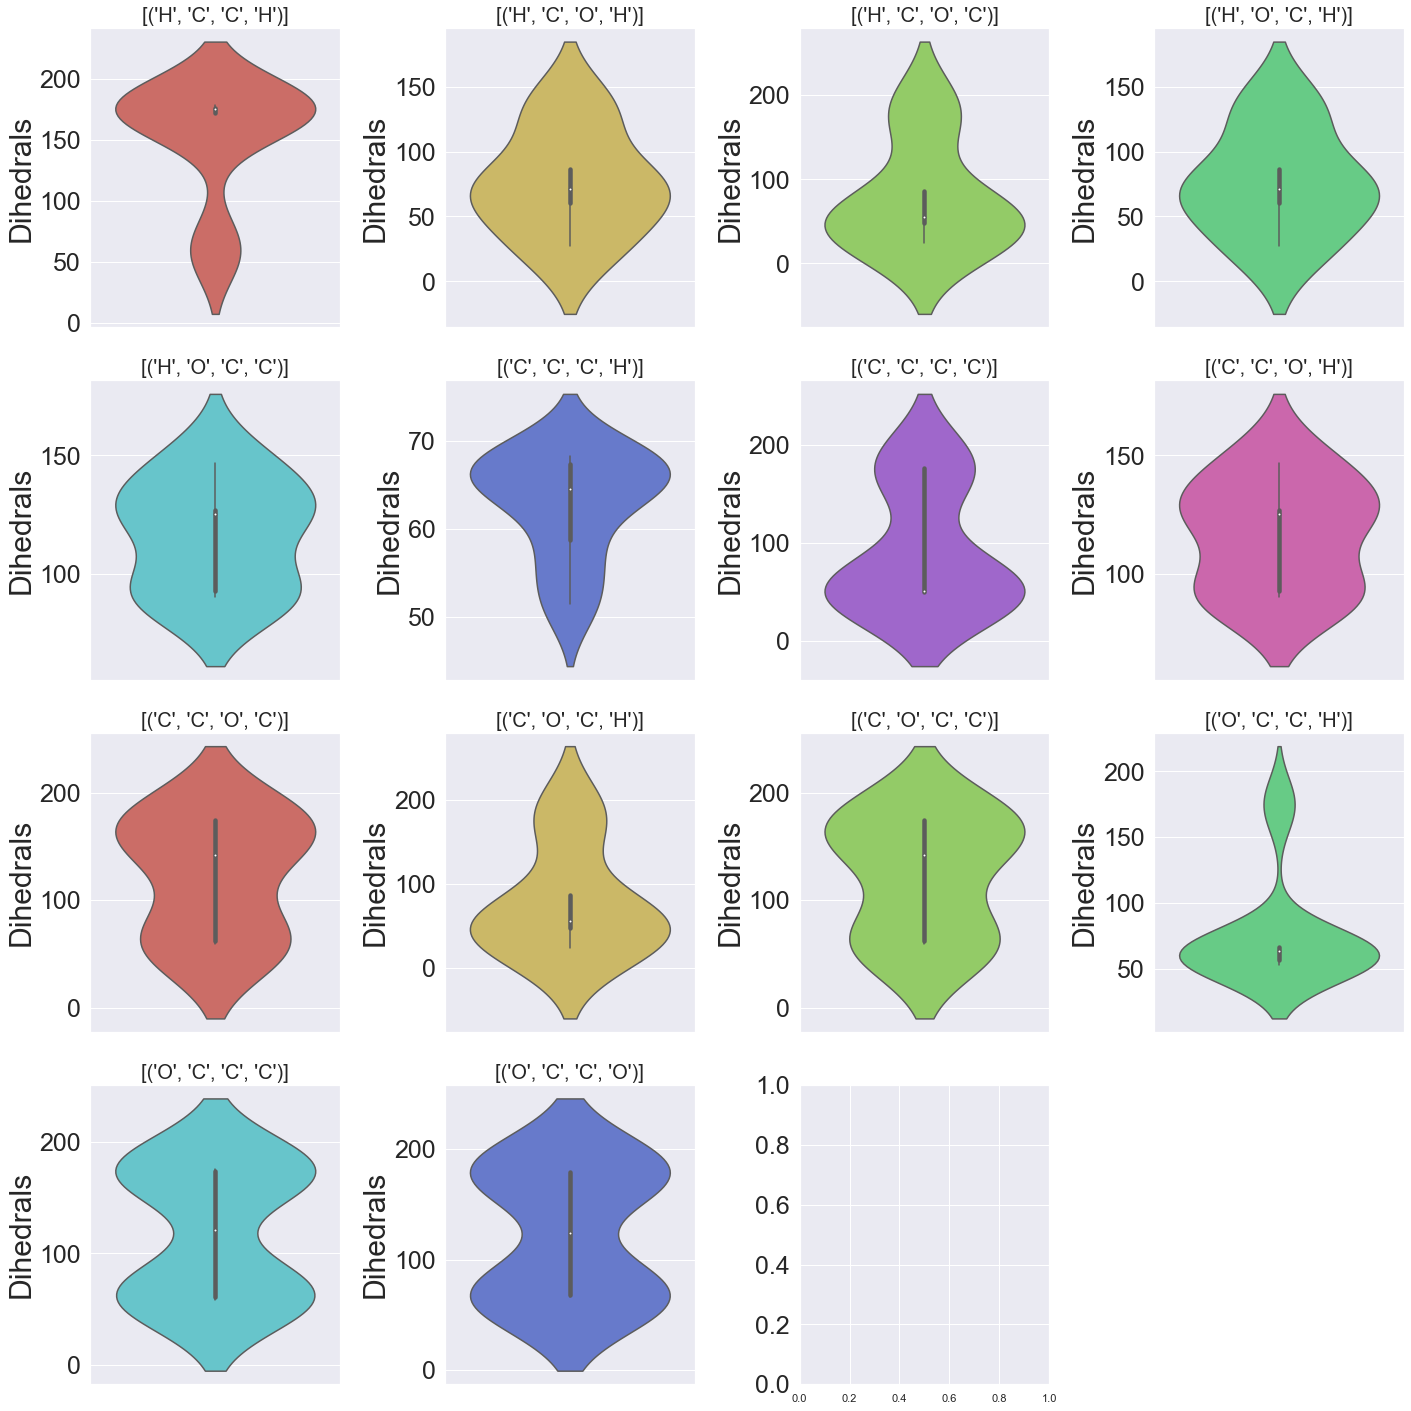

In [58]:
Dihedralssns = Dihedralssdf.drop(['Atom Numbers'], axis=1)
Dihedralssns = Dihedralssns.explode('Dihedrals')
Dihedralssns = Dihedralssns.explode('Dihedrals')
Dihedralssns['Dihedrals'] = Dihedralssns['Dihedrals'].astype('float')
Dihedralssns = Dihedralssns.set_index('Atoms')

Dihedralssns = Dihedralssns.loc[(Dihedralssns['Dihedrals']>20) & (Dihedralssns['Dihedrals']< 179.99999)]



# This is important as when there is only a few dihedrals violinplots are a little pointless. 
# It also suggests the dihedral is not very useful
count_freq = dict(Dihedralssns.index.value_counts())

Dihedralssns['count_freq'] = Dihedralssns.index
Dihedralssns['count_freq'] = Dihedralssns['count_freq'].map(count_freq)
Dihedralssns = Dihedralssns[Dihedralssns.count_freq>4]


nplots = len(set(Dihedralssns.index.tolist()))

if nplots <= 6:
    ncol = 2
elif nplots <= 9:
    ncol = 3
elif nplots <= 16:
    ncol = 4

nrow = int(nplots / 4) + (nplots % 4 > 0)


# useful for debugging
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#       display(Dihedralssns)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"font.size":20,"axes.titlesize":20,"axes.labelsize":30, "ytick.labelsize":25})
palette = cycle(sns.color_palette("hls", 8))

fig, ax = plt.subplots(nrow, ncol, figsize=(20, 20))

counter = 0
for j in Dihedralssdf["Atoms"]:
    if j in Dihedralssns.index:
        sns.violinplot(y="Dihedrals", data=Dihedralssns.loc[[j]], ax=ax.flat[counter], color=next(palette)).set_title([j])
        counter += 1


if (nplots % ncol > 0) == 1:
    ax.flat[-1].set_visible(False)
    
plt.tight_layout()
plt.show();

In [59]:
list()

[]